In [18]:
import pandas as pd

A= pd.read_csv('C:/Users/veryv/OneDrive/桌面/Stock_data/full_history/A.csv', index_col=0 )
A.dropna(how='any',inplace=True)
A = A.astype("float32")

In [19]:
A.head()

,volume,open,close,high,low,adjclose
date,,,,,,
2019-04-18,2874100.0,75.730003,76.169998,76.540001,75.309998,76.169998
2019-04-17,4472000.0,78.150002,75.430000,78.320000,74.459999,75.430000
2019-04-16,3441500.0,80.820000,77.550003,80.959999,77.190002,77.550003
2019-04-15,1627300.0,81.000000,80.400002,81.129997,79.910004,80.400002
2019-04-12,1249300.0,81.430000,80.980003,82.059998,80.900002,80.980003


In [20]:
from sklearn import preprocessing


def normalize(x):
    newx= x.copy()
    scaler = preprocessing.MinMaxScaler()

    newx['open'] = scaler.fit_transform(x.open.values.reshape(-1,1))
    newx['low'] = scaler.fit_transform(x.low.values.reshape(-1,1))
    newx['high'] = scaler.fit_transform(x.high.values.reshape(-1,1))
    newx['volume'] = scaler.fit_transform(x.volume.values.reshape(-1,1))
    newx['close'] = scaler.fit_transform(x.close.values.reshape(-1,1))
    newx['adjclose'] = scaler.fit_transform(x.adjclose.values.reshape(-1,1))
    return newx

A = normalize(A)
df = pd.DataFrame(A)

In [21]:
class StockDataset():
    def __init__(self, arr):
        self.arr = arr
        
    def __getitem__(self, item):
        x = self.arr[item:item+30,:]
        y = self.arr[item+30,5]
        return x, y
    
    def __len__(self):
        return self.arr.shape[0]-30

In [22]:
import numpy as np
import torch

    
# 資料維度: 開盤價、收盤價、最高價、最低價、成交量, 5維
number_features = len(A.columns)

# 將dataframe 轉成 numpy array
train_set = StockDataset(df.values)

x, y = train_set[0]
print(x)
print('----------------')
print(y)

[[0.03775623 0.6549934  0.6455326  0.63546705 0.70470905 0.7550105 ]
 [0.06352317 0.6782774  0.6385497  0.65196097 0.6958742  0.746964  ]
 [0.04690584 0.7039667  0.65855485 0.6764239  0.72424996 0.7700162 ]
 [0.01765097 0.70569855 0.6854485  0.67799914 0.75252175 0.8010061 ]
 [0.01155553 0.70983577 0.69092166 0.6866168  0.7628119  0.80731285]
 [0.00868842 0.71416545 0.69186527 0.6853195  0.76270795 0.8084002 ]
 [0.0072597  0.7100282  0.6975271  0.6882847  0.7685286  0.81492436]
 [0.01164261 0.7110866  0.6950736  0.68346626 0.7666576  0.8120972 ]
 [0.00404105 0.7111828  0.69762146 0.6833736  0.75948584 0.81503314]
 [0.01564495 0.7075267  0.6955455  0.6853195  0.76437104 0.8126409 ]
 [0.02656514 0.7137806  0.6895062  0.68652415 0.75803065 0.80568177]
 [0.02593463 0.71089417 0.69998056 0.6862461  0.76863253 0.8177516 ]
 [0.01080892 0.7125298  0.69243145 0.68383694 0.76416314 0.8090526 ]
 [0.01596424 0.7053137  0.6963947  0.68392956 0.7634355  0.8136195 ]
 [0.01697047 0.6976166  0.68525976

In [23]:
import numpy as np
import torch
import torch.utils.data as Data
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
   # reproducible
BATCH_SIZE = 20 # 批训练的数据个数
EPOCH = 50
TIME_STEP = 30
INPUT_SIZE = 6
HIDDEN_SIZE = 64
OUTPUT_SIZE = 1
LR = 0.00001
# 先转换成 torch 能识别的 Dataset
train_loader = Data.DataLoader(
    dataset = train_set,
    batch_size = BATCH_SIZE,
    shuffle= False,  
    num_workers = 0
)

In [24]:
if __name__ == '__main__':    
    class RNN(nn.Module):
        def __init__(self, input_size, hidden_size, output_size):
            super(RNN, self).__init__()

            self.rnn = nn.LSTM(         # if use nn.RNN(), it hardly learns
                input_size=input_size,
                hidden_size=hidden_size,         # rnn hidden unit
                num_layers=4,           # number of rnn layer
                batch_first=False,       # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
            )

            self.out = nn.Linear(30*hidden_size, output_size)

        def forward(self, x):
            # x shape (batch, time_step, input_size)
            # r_out shape (batch, time_step, output_size)
            # h_n shape (n_layers, batch, hidden_size)
            # h_c shape (n_layers, batch, hidden_size)
            r_out, (h_n, h_c) = self.rnn(x, None)   # None represents zero initial hidden state
            # choose r_out at the last time step
            r_out = r_out.reshape(r_out.shape[0], r_out.shape[1]*r_out.shape[2])
            out = self.out(r_out)
            #out = out.view(BATCH_SIZE, 6)
            return out

model = RNN(INPUT_SIZE, HIDDEN_SIZE, OUTPUT_SIZE)

In [29]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_func = nn.MSELoss()

model = model.train()
for epoch in range(EPOCH):
    train_loss = 0
    for data in train_loader:
        x, y = data
        #forward
        outputs= model(x)
        loss = loss_func(outputs, y.unsqueeze(1))
        
        ##backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    print('epoch: {}, perplexity is: {:.3f}'.format(epoch+1, np.exp(train_loss / len(train_loader))))
# 
###       if step % 50 == 0:
#             test_output = rnn(test_x)
#             pred_y = np.squeeze(torch.max(test_output, 1)[1].data.numpy())
#             accuracy = float((pred_y == test_y).astype(int).sum()) / float(test_y.size)
#             print('Epoch: ', epoch, ' | train loss: %.4f' % loss.data.numpy(), ' | test accuracy: %.2f' % accuracy )

epoch: 1, perplexity is: 1.081
epoch: 2, perplexity is: 1.045
epoch: 3, perplexity is: 1.037
epoch: 4, perplexity is: 1.035
epoch: 5, perplexity is: 1.035
epoch: 6, perplexity is: 1.034
epoch: 7, perplexity is: 1.034
epoch: 8, perplexity is: 1.034
epoch: 9, perplexity is: 1.033
epoch: 10, perplexity is: 1.032
epoch: 11, perplexity is: 1.031
epoch: 12, perplexity is: 1.029
epoch: 13, perplexity is: 1.025
epoch: 14, perplexity is: 1.019
epoch: 15, perplexity is: 1.014
epoch: 16, perplexity is: 1.012
epoch: 17, perplexity is: 1.012
epoch: 18, perplexity is: 1.011
epoch: 19, perplexity is: 1.011
epoch: 20, perplexity is: 1.011
epoch: 21, perplexity is: 1.011
epoch: 22, perplexity is: 1.010
epoch: 23, perplexity is: 1.010
epoch: 24, perplexity is: 1.010
epoch: 25, perplexity is: 1.010
epoch: 26, perplexity is: 1.010
epoch: 27, perplexity is: 1.009
epoch: 28, perplexity is: 1.009
epoch: 29, perplexity is: 1.009
epoch: 30, perplexity is: 1.009
epoch: 31, perplexity is: 1.009
epoch: 32, perple

In [30]:
model = model.eval()

In [31]:
for data in train_loader:
    x, y = data
    print('ground_truth: ', y)
    outputs = model(x)
    print('predict: ', outputs.view(-1))

ground_truth:  tensor([0.7811, 0.7813, 0.7921, 0.7963, 0.8083, 0.7888, 0.7886, 0.7791, 0.7877,
        0.7777, 0.7720, 0.7793, 0.7680, 0.7764, 0.7625, 0.7650, 0.7631, 0.7523,
        0.7493, 0.7442])
predict:  tensor([0.2075, 0.3081, 0.3828, 0.4560, 0.5293, 0.5966, 0.6525, 0.6942, 0.7220,
        0.7378, 0.7445, 0.7450, 0.7417, 0.7363, 0.7300, 0.7238, 0.7179, 0.7128,
        0.7083, 0.7044], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.7547, 0.7548, 0.7518, 0.7519, 0.7520, 0.7454, 0.7250, 0.7219, 0.7260,
        0.7100, 0.7043, 0.7007, 0.7073, 0.6953, 0.6867, 0.6929, 0.6837, 0.6905,
        0.6853, 0.6782])
predict:  tensor([0.2069, 0.3059, 0.3778, 0.4474, 0.5167, 0.5802, 0.6326, 0.6714, 0.6967,
        0.7105, 0.7155, 0.7145, 0.7096, 0.7027, 0.6949, 0.6871, 0.6795, 0.6725,
        0.6662, 0.6605], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.6628, 0.6522, 0.6371, 0.6133, 0.6396, 0.6588, 0.6425, 0.6464, 0.6362,
        0.6051, 0.6119, 0.6324, 0.6502, 0.6627, 0.6612, 0.6776, 0.6

        0.5456, 0.5415], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.5713, 0.5685, 0.5669, 0.5700, 0.5682, 0.5661, 0.5749, 0.5852, 0.5838,
        0.5796, 0.5839, 0.5821, 0.5857, 0.5854, 0.5819, 0.5769, 0.5670, 0.5676,
        0.5652, 0.5608])
predict:  tensor([0.2013, 0.2848, 0.3324, 0.3728, 0.4126, 0.4502, 0.4824, 0.5072, 0.5244,
        0.5346, 0.5394, 0.5403, 0.5386, 0.5357, 0.5322, 0.5287, 0.5256, 0.5230,
        0.5207, 0.5188], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.5667, 0.5598, 0.5617, 0.5563, 0.5613, 0.5557, 0.5596, 0.5652, 0.5742,
        0.5655, 0.5712, 0.5736, 0.5625, 0.5593, 0.5611, 0.5600, 0.5569, 0.5593,
        0.5693, 0.5744])
predict:  tensor([0.2007, 0.2826, 0.3279, 0.3657, 0.4031, 0.4389, 0.4702, 0.4949, 0.5124,
        0.5235, 0.5292, 0.5311, 0.5304, 0.5283, 0.5255, 0.5225, 0.5196, 0.5170,
        0.5147, 0.5127], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.5688, 0.5720, 0.5763, 0.5755, 0.5713, 0.5716, 0.5625, 0.5602, 0.5595,
        0.5534, 0.

        0.3556, 0.3675])
predict:  tensor([0.1929, 0.2539, 0.2665, 0.2652, 0.2630, 0.2633, 0.2658, 0.2692, 0.2727,
        0.2756, 0.2776, 0.2788, 0.2794, 0.2795, 0.2794, 0.2793, 0.2793, 0.2796,
        0.2801, 0.2809], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.3700, 0.3720, 0.3659, 0.3697, 0.3658, 0.3601, 0.3560, 0.3483, 0.3554,
        0.3623, 0.3557, 0.3499, 0.3492, 0.3604, 0.3575, 0.3595, 0.3546, 0.3588,
        0.3488, 0.3516])
predict:  tensor([0.1931, 0.2548, 0.2687, 0.2695, 0.2698, 0.2729, 0.2783, 0.2847, 0.2908,
        0.2961, 0.3003, 0.3035, 0.3057, 0.3073, 0.3084, 0.3092, 0.3099, 0.3106,
        0.3112, 0.3119], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.3584, 0.3664, 0.3679, 0.3613, 0.3543, 0.3475, 0.3397, 0.3315, 0.3403,
        0.3302, 0.3192, 0.3133, 0.3208, 0.3226, 0.3260, 0.3254, 0.3277, 0.3294,
        0.3298, 0.3290])
predict:  tensor([0.1939, 0.2579, 0.2752, 0.2797, 0.2837, 0.2897, 0.2970, 0.3041, 0.3101,
        0.3144, 0.3170, 0.3180, 0.3177, 0.3165,

        0.3109, 0.3108], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.3533, 0.3543, 0.3554, 0.3530, 0.3564, 0.3613, 0.3602, 0.3650, 0.3621,
        0.3580, 0.3593, 0.3586, 0.3624, 0.3622, 0.3651, 0.3631, 0.3601, 0.3516,
        0.3499, 0.3474])
predict:  tensor([0.1939, 0.2577, 0.2748, 0.2790, 0.2826, 0.2881, 0.2951, 0.3022, 0.3084,
        0.3134, 0.3170, 0.3194, 0.3208, 0.3215, 0.3218, 0.3219, 0.3219, 0.3219,
        0.3219, 0.3219], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.3478, 0.3479, 0.3490, 0.3429, 0.3422, 0.3374, 0.3334, 0.3283, 0.3332,
        0.3337, 0.3297, 0.3397, 0.3470, 0.3439, 0.3363, 0.3357, 0.3337, 0.3335,
        0.3359, 0.3300])
predict:  tensor([0.1942, 0.2588, 0.2769, 0.2823, 0.2869, 0.2932, 0.3004, 0.3074, 0.3130,
        0.3169, 0.3192, 0.3200, 0.3198, 0.3189, 0.3177, 0.3164, 0.3152, 0.3139,
        0.3127, 0.3115], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.3295, 0.3263, 0.3209, 0.3240, 0.3289, 0.3355, 0.3335, 0.3332, 0.3311,
        0.3309, 0.

        0.1971, 0.1980])
predict:  tensor([0.1906, 0.2456, 0.2490, 0.2370, 0.2240, 0.2147, 0.2092, 0.2065, 0.2056,
        0.2056, 0.2057, 0.2057, 0.2054, 0.2048, 0.2039, 0.2028, 0.2017, 0.2005,
        0.1992, 0.1980], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1938, 0.1862, 0.1894, 0.1983, 0.1860, 0.1856, 0.1884, 0.1898, 0.1933,
        0.1940, 0.1938, 0.1988, 0.2039, 0.1990, 0.1946, 0.1953, 0.1873, 0.1869,
        0.1882, 0.1863])
predict:  tensor([0.1898, 0.2426, 0.2427, 0.2267, 0.2098, 0.1969, 0.1886, 0.1838, 0.1814,
        0.1804, 0.1802, 0.1803, 0.1804, 0.1804, 0.1804, 0.1802, 0.1799, 0.1796,
        0.1791, 0.1786], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1838, 0.1874, 0.1856, 0.1920, 0.2023, 0.2012, 0.1959, 0.1962, 0.1992,
        0.1976, 0.2029, 0.2066, 0.2081, 0.2105, 0.2090, 0.2082, 0.2081, 0.2051,
        0.2050, 0.2028])
predict:  tensor([0.1892, 0.2405, 0.2382, 0.2197, 0.2006, 0.1859, 0.1765, 0.1714, 0.1692,
        0.1688, 0.1695, 0.1706, 0.1718, 0.1731,

        0.2551, 0.2550], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.2900, 0.2933, 0.2973, 0.2933, 0.3016, 0.3034, 0.2873, 0.2852, 0.2898,
        0.2841, 0.2830, 0.2790, 0.2814, 0.2893, 0.2881, 0.2843, 0.2872, 0.2852,
        0.2807, 0.2719])
predict:  tensor([0.1919, 0.2504, 0.2593, 0.2538, 0.2477, 0.2447, 0.2448, 0.2468, 0.2497,
        0.2526, 0.2552, 0.2572, 0.2587, 0.2597, 0.2604, 0.2608, 0.2612, 0.2615,
        0.2618, 0.2621], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.2802, 0.2752, 0.2616, 0.2605, 0.2670, 0.2608, 0.2605, 0.2487, 0.2491,
        0.2483, 0.2482, 0.2512, 0.2516, 0.2479, 0.2501, 0.2476, 0.2498, 0.2460,
        0.2417, 0.2423])
predict:  tensor([0.1921, 0.2513, 0.2611, 0.2567, 0.2515, 0.2491, 0.2492, 0.2508, 0.2527,
        0.2544, 0.2554, 0.2558, 0.2554, 0.2546, 0.2533, 0.2519, 0.2503, 0.2486,
        0.2469, 0.2452], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.2413, 0.2396, 0.2362, 0.2416, 0.2344, 0.2309, 0.2300, 0.2407, 0.2480,
        0.2516, 0.

        0.1193, 0.1164])
predict:  tensor([0.1875, 0.2344, 0.2256, 0.1995, 0.1729, 0.1517, 0.1369, 0.1277, 0.1224,
        0.1198, 0.1188, 0.1184, 0.1184, 0.1184, 0.1182, 0.1179, 0.1175, 0.1170,
        0.1164, 0.1159], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1231, 0.1217, 0.1246, 0.1244, 0.1223, 0.1235, 0.1236, 0.1231, 0.1209,
        0.1218, 0.1189, 0.1152, 0.1174, 0.1261, 0.1266, 0.1266, 0.1243, 0.1261,
        0.1293, 0.1311])
predict:  tensor([0.1869, 0.2324, 0.2213, 0.1927, 0.1639, 0.1409, 0.1249, 0.1149, 0.1094,
        0.1069, 0.1063, 0.1067, 0.1075, 0.1083, 0.1091, 0.1098, 0.1104, 0.1109,
        0.1114, 0.1119], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1332, 0.1300, 0.1309, 0.1319, 0.1296, 0.1281, 0.1277, 0.1263, 0.1213,
        0.1160, 0.1120, 0.1079, 0.1074, 0.1119, 0.1107, 0.1118, 0.1097, 0.1093,
        0.1083, 0.1094])
predict:  tensor([0.1869, 0.2324, 0.2215, 0.1932, 0.1648, 0.1424, 0.1271, 0.1178, 0.1130,
        0.1111, 0.1109, 0.1116, 0.1125, 0.1134,

        0.1544, 0.1532], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1423, 0.1445, 0.1356, 0.1435, 0.1426, 0.1484, 0.1493, 0.1525, 0.1529,
        0.1539, 0.1522, 0.1505, 0.1481, 0.1405, 0.1387, 0.1361, 0.1416, 0.1440,
        0.1442, 0.1392])
predict:  tensor([0.1882, 0.2369, 0.2307, 0.2075, 0.1835, 0.1644, 0.1511, 0.1429, 0.1383,
        0.1361, 0.1353, 0.1354, 0.1358, 0.1362, 0.1366, 0.1368, 0.1369, 0.1368,
        0.1367, 0.1365], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1370, 0.1450, 0.1393, 0.1391, 0.1453, 0.1448, 0.1441, 0.1384, 0.1422,
        0.1427, 0.1460, 0.1453, 0.1470, 0.1460, 0.1535, 0.1562, 0.1551, 0.1524,
        0.1518, 0.1532])
predict:  tensor([0.1877, 0.2352, 0.2272, 0.2022, 0.1767, 0.1566, 0.1428, 0.1345, 0.1301,
        0.1283, 0.1280, 0.1286, 0.1295, 0.1304, 0.1313, 0.1321, 0.1327, 0.1333,
        0.1338, 0.1342], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1526, 0.1483, 0.1463, 0.1527, 0.1609, 0.1549, 0.1550, 0.1560, 0.1590,
        0.1677, 0.

        0.1355, 0.1360])
predict:  tensor([0.1885, 0.2380, 0.2331, 0.2116, 0.1896, 0.1724, 0.1609, 0.1542, 0.1508,
        0.1495, 0.1494, 0.1499, 0.1505, 0.1510, 0.1514, 0.1516, 0.1517, 0.1516,
        0.1513, 0.1509], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1384, 0.1394, 0.1366, 0.1339, 0.1322, 0.1339, 0.1399, 0.1395, 0.1438,
        0.1428, 0.1384, 0.1347, 0.1324, 0.1331, 0.1329, 0.1353, 0.1382, 0.1414,
        0.1447, 0.1428])
predict:  tensor([0.1882, 0.2368, 0.2306, 0.2074, 0.1836, 0.1648, 0.1519, 0.1440, 0.1397,
        0.1378, 0.1373, 0.1375, 0.1381, 0.1386, 0.1390, 0.1393, 0.1393, 0.1393,
        0.1392, 0.1390], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1368, 0.1189, 0.1104, 0.1144, 0.1109, 0.1096, 0.1141, 0.1161, 0.1171,
        0.1166, 0.1161, 0.1187, 0.1152, 0.1126, 0.1145, 0.1236, 0.1228, 0.1148,
        0.1210, 0.1252])
predict:  tensor([0.1878, 0.2357, 0.2282, 0.2035, 0.1782, 0.1581, 0.1440, 0.1351, 0.1301,
        0.1276, 0.1266, 0.1264, 0.1265, 0.1268,

        0.0794, 0.0800], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.0843, 0.0882, 0.0888, 0.0912, 0.0938, 0.0895, 0.0917, 0.0911, 0.0920,
        0.0888, 0.0857, 0.0833, 0.0819, 0.0853, 0.0859, 0.0867, 0.0883, 0.0914,
        0.0889, 0.0869])
predict:  tensor([0.1857, 0.2280, 0.2124, 0.1788, 0.1454, 0.1188, 0.1002, 0.0888, 0.0827,
        0.0802, 0.0800, 0.0811, 0.0826, 0.0843, 0.0858, 0.0871, 0.0882, 0.0891,
        0.0898, 0.0904], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.0823, 0.0826, 0.0871, 0.0828, 0.0783, 0.0759, 0.0800, 0.0788, 0.0760,
        0.0726, 0.0753, 0.0753, 0.0739, 0.0715, 0.0739, 0.0769, 0.0757, 0.0782,
        0.0756, 0.0733])
predict:  tensor([0.1861, 0.2293, 0.2149, 0.1827, 0.1504, 0.1246, 0.1065, 0.0950, 0.0886,
        0.0855, 0.0846, 0.0848, 0.0854, 0.0862, 0.0869, 0.0873, 0.0876, 0.0876,
        0.0875, 0.0873], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.0765, 0.0767, 0.0793, 0.0801, 0.0802, 0.0836, 0.0837, 0.0880, 0.0894,
        0.0894, 0.

        0.0702, 0.0686])
predict:  tensor([0.1862, 0.2297, 0.2158, 0.1841, 0.1524, 0.1270, 0.1093, 0.0981, 0.0920,
        0.0893, 0.0887, 0.0892, 0.0903, 0.0916, 0.0928, 0.0939, 0.0947, 0.0952,
        0.0954, 0.0954], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.0664, 0.0663, 0.0657, 0.0674, 0.0723, 0.0722, 0.0734, 0.0722, 0.0749,
        0.0751, 0.0734, 0.0727, 0.0729, 0.0718, 0.0652, 0.0701, 0.0692, 0.0749,
        0.0768, 0.0763])
predict:  tensor([0.1861, 0.2295, 0.2152, 0.1829, 0.1503, 0.1241, 0.1054, 0.0934, 0.0864,
        0.0829, 0.0815, 0.0813, 0.0816, 0.0821, 0.0825, 0.0828, 0.0829, 0.0828,
        0.0826, 0.0823], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.0732, 0.0689, 0.0737, 0.0731, 0.0705, 0.0617, 0.0638, 0.0612, 0.0587,
        0.0587, 0.0574, 0.0545, 0.0533, 0.0543, 0.0554, 0.0568, 0.0588, 0.0566,
        0.0566, 0.0545])
predict:  tensor([0.1857, 0.2279, 0.2120, 0.1779, 0.1438, 0.1163, 0.0968, 0.0842, 0.0770,
        0.0733, 0.0720, 0.0719, 0.0723, 0.0730,

        0.1433, 0.1414], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1101, 0.1197, 0.1266, 0.1316, 0.1255, 0.1242, 0.1268, 0.1229, 0.1211,
        0.1158, 0.1101, 0.1190, 0.1250, 0.1216, 0.1323, 0.1321, 0.1363, 0.1409,
        0.1426, 0.1478])
predict:  tensor([0.1876, 0.2349, 0.2266, 0.2009, 0.1747, 0.1537, 0.1390, 0.1296, 0.1242,
        0.1214, 0.1201, 0.1197, 0.1196, 0.1195, 0.1195, 0.1194, 0.1194, 0.1194,
        0.1196, 0.1200], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1471, 0.1480, 0.1367, 0.1242, 0.1192, 0.1222, 0.1214, 0.1164, 0.1192,
        0.1154, 0.1137, 0.1195, 0.1213, 0.1219, 0.1214, 0.1193, 0.1341, 0.1245,
        0.1289, 0.1303])
predict:  tensor([0.1873, 0.2338, 0.2245, 0.1980, 0.1713, 0.1504, 0.1361, 0.1275, 0.1231,
        0.1214, 0.1214, 0.1221, 0.1232, 0.1242, 0.1251, 0.1257, 0.1261, 0.1264,
        0.1266, 0.1268], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.1276, 0.1288, 0.1168, 0.1125, 0.1108, 0.1102, 0.1087, 0.1090, 0.1039,
        0.0962, 0.

        0.4246, 0.4389])
predict:  tensor([0.1918, 0.2499, 0.2579, 0.2508, 0.2424, 0.2367, 0.2338, 0.2334, 0.2352,
        0.2387, 0.2436, 0.2495, 0.2559, 0.2624, 0.2687, 0.2748, 0.2805, 0.2862,
        0.2920, 0.2982], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.4634, 0.4360, 0.4339, 0.4339, 0.4381, 0.4566, 0.4237, 0.3858, 0.3495,
        0.3718, 0.3841, 0.3929, 0.3723, 0.4052, 0.3934, 0.3790, 0.4060, 0.4600,
        0.4786, 0.4195])
predict:  tensor([0.1941, 0.2592, 0.2791, 0.2882, 0.2984, 0.3120, 0.3279, 0.3442, 0.3593,
        0.3721, 0.3822, 0.3899, 0.3957, 0.4000, 0.4030, 0.4054, 0.4072, 0.4086,
        0.4097, 0.4107], grad_fn=<ViewBackward>)
ground_truth:  tensor([0.4237, 0.4355, 0.3655, 0.3908, 0.3250, 0.3183, 0.3478, 0.3765, 0.4060,
        0.4533, 0.5241, 0.5220, 0.5381, 0.4436, 0.4465, 0.4680, 0.4988, 0.5440,
        0.5359, 0.5444])
predict:  tensor([0.1971, 0.2695, 0.3000, 0.3201, 0.3395, 0.3588, 0.3761, 0.3896, 0.3989,
        0.4043, 0.4070, 0.4081, 0.4086, 0.4095,

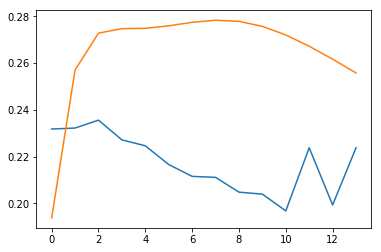

In [32]:
y1 = np.array(y)
out = outputs.view(-1).detach().numpy()
plt.plot(y1)
plt.plot(out)